# Forest inventory

* **Start Jupyter:** To run this notebook interactively from your browser

### Background

Forests are complex biomes. Anaylzing them is an important task to enhance the understanding, also in the context of the current global change. Forests have an important role, e.g. econmical or as carbon sink, which can also be conenected to monetary aspects (CO2 certificates). Furhter societal benefits are in the context of healthcare, e.g. allergies or considering upcoming zoonoses like the Covid-19 pandemic as well as forests role in recreation.


This example tries to demonstrate a potential workflow from loading and processing (cloud removal, median-mosaicing, index calculation) satellite raster-data togehter with additional on-demand vector-data nd export them as cloud-optimized-geotiff for individual processing, e.g. in a local GIS.

### Preliminary steps

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import scipy
import matplotlib.colors as mcolours

import matplotlib.pyplot as plt
import sys
import dask.distributed
import dask.utils
import numpy as np
import planetary_computer as pc
import xarray as xr
from IPython.display import display
from pystac_client import Client
from numpy.typing import DTypeLike
from odc.stac import configure_rio, stac_load
from datacube.utils.cog import write_cog
import gc
from dea_tools.plotting import map_shapefile, rgb
from sklearn.preprocessing import StandardScaler
from dea_tools.classification import sklearn_flatten, sklearn_unflatten, KMeans_tree, fit_xr
from sklearn.cluster import KMeans


from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer

In [2]:
!pip install dea_tools pystac-client 

  Using cached dea_tools-0.2.7-py3-none-any.whl (143 kB)
  Using cached ciso8601-2.3.0-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39 kB)
  Using cached lxml-4.9.3-cp311-cp311-manylinux_2_28_x86_64.whl (7.9 MB)
  Using cached rasterstats-0.19.0-py3-none-any.whl (16 kB)
  Using cached odc_ui-0.2.0a3-py3-none-any.whl (15 kB)
  Using cached OWSLib-0.29.2-py2.py3-none-any.whl (221 kB)
  Using cached jupyter_ui_poll-0.2.2-py2.py3-none-any.whl (9.0 kB)
  Using cached simplejson-3.19.1-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (144 kB)


### Loading your area of interest as sahepfile (here: different conservation zones in Rhoen Highlands)

In [4]:
rhoen = gpd.read_file('bwi2012.geojson')

In [5]:
tr_nr_17020 = rhoen.loc[rhoen['Tnr'] == 17020]

## Load Sentinel-2 data from the datacube

Here we are loading a timeseries of `Sentinel-2` satellite images through the datacube API.(official coordinate system ['EPSG:25832'](https://www.ldbv.bayern.de/file/pdf/12867/Faltblatt_UTM-Umstellung.pdf))

In [6]:
# to catalog variable
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
# from rhoen extent
x_min=9.4
x_max=10.5
y_min=49.7
y_max=51.2

area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [x_max, y_min],
            [x_min, y_min],
            [x_min, y_max],
            [x_max, y_max],
            [x_max, y_min],
        ]
    ],}

time_extents = ('2015-01-01', '2022-12-31')

In [7]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_extents,
    #query={"eo:cloud_cover": {"lt": 100}},
)

# Check how many items were returned
items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 3673 Items


In [8]:
# Write ccordinates from tract
minx = tr_nr_17020.bounds.iloc[0,0]
maxx = tr_nr_17020.bounds.iloc[0,2]
miny = tr_nr_17020.bounds.iloc[0,1]
maxy = tr_nr_17020.bounds.iloc[0,3]

x_min = minx
x_max = maxx
y_min = miny
y_max = maxy

In [9]:
# Lazy load data using dask-chunks
dataset = stac_load(items,
                    crs='EPSG:25832',
                    y= [y_min, y_max],
                    x= [x_min, x_max],
                    resolution=10,
                    chunks={},
                    groupby="solar_day",
                    patch_url=pc.sign)
# Take a look at the dataset
dataset

<xarray.Dataset>
Dimensions:      (y: 227, x: 227, time: 931)
Coordinates:
  * y            (y) float64 5.581e+06 5.581e+06 ... 5.579e+06 5.579e+06
  * x            (x) float64 5.755e+05 5.755e+05 ... 5.777e+05 5.777e+05
    spatial_ref  int32 25832
  * time         (time) datetime64[ns] 2015-07-30T10:30:16.027000 ... 2022-12...
Data variables: (12/16)
    AOT          (time, y, x) float32 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    B01          (time, y, x) float32 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    B02          (time, y, x) float32 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    B03          (time, y, x) float32 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    B04          (time, y, x) float32 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    B05          (time, y, x) float32 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    ...           ...
    B11          (time, y, x) float32 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    B12          (time, y, x) float32 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    B8A          (time, y, x) float32 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    SCL          (time, y, x) float32 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    WVP          (time, y, x) float32 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    visual       (time, y, x) float32 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>

In [10]:
# Rename bands
dataset['coastal_aerosol'] = dataset.B01
dataset['blue'] = dataset.B02
dataset['green'] = dataset.B03
dataset['red'] = dataset.B04
dataset['red_edge1'] = dataset.B05
dataset['red_edge2'] = dataset.B06
dataset['red_edge3'] = dataset.B07
dataset['nir'] = dataset.B08
dataset['narrow_nir'] = dataset.B8A
dataset['water_vapour'] = dataset.B09
dataset['swir1'] = dataset.B11
dataset['swir2'] = dataset.B12

dataset = dataset.drop(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12'])

In [11]:
# Load lazy loaded data
dataset = dataset.compute()

Apply a Sentinel-2 scene classification (scl-band) for masking clouds

In [12]:
#scl_dict = {'0': 'no_data','1': 'defect','2': 'dark','3': 'cloud_shadow','4': 'vegetation','5': 'no_vegetation',
#'6': 'water','7': 'no_class','8': 'cloud_med_prob','9': 'cloud_high_prob','10': 'cirrus','11': 'snow'}
mask = dataset.SCL.isin([4,5,6,7,11])
dataset['mask'] = mask
dataset = dataset.where(dataset.SCL.isin([4, 5, 6, 7,11]))

In [13]:
# percent share of clouds for accepting usage
cloud_percent = .1

clean_dataset=dataset.sel(time=pd.to_datetime(((dataset.sum(dim=['x','y'])/  ((dataset.dims)['y']*(dataset.dims)['x'])).time.where(
    ((dataset.sum(dim=['x','y'])/((dataset.dims)['y']*(dataset.dims)['x'])).mask) > cloud_percent,drop=True)).values.tolist()))

In [14]:
clean_dataset.time.count(), dataset.time.count()

(<xarray.DataArray 'time' ()>
 array(382)
 Coordinates:
     spatial_ref  int32 25832,
 <xarray.DataArray 'time' ()>
 array(931)
 Coordinates:
     spatial_ref  int32 25832)

### Create a test dataset

In [15]:
NDVI8A = (dataset.narrow_nir - dataset.red)/(dataset.narrow_nir + dataset.red)
NDVI8 = (dataset.nir - dataset.red)/(dataset.nir + dataset.red)
NDWI8 = (dataset.nir - dataset.swir2)/(dataset.nir + dataset.swir2)
NDWI8A = (dataset.narrow_nir - dataset.swir2)/(dataset.narrow_nir + dataset.swir2)
#
EVI = (2.5 * (dataset.narrow_nir - dataset.red))/(dataset.narrow_nir + 6 * dataset.red - 7.5 * dataset.blue + 1)
#
NIRv = ((dataset.narrow_nir - dataset.red) / (dataset.narrow_nir - dataset.red))*dataset.narrow_nir
#
NDVIb = (dataset.nir - dataset.blue)/(dataset.nir + dataset.blue)
#
Clr = ((dataset.red_edge3 - dataset.red_edge1)-1)
#
Clg = ((dataset.red_edge3 - dataset.green)-1)
#
MTCI = (dataset.red_edge2 - dataset.red_edge1)/(dataset.red_edge1 - dataset.red)
#
NDRE1 = (dataset.red_edge2 - dataset.red_edge1)/(dataset.red_edge1 + dataset.red_edge1)
#
NDRE2 = (dataset.narrow_nir - dataset.red_edge1)/(dataset.narrow_nir + dataset.red_edge1)
DD = (dataset.red_edge1 - dataset.red)/(dataset.red_edge3 - dataset.red_edge2)

dataset['dd'] = DD

dataset['ndvi8a'] = NDVI8A

dataset['ndvi8'] = NDVI8
dataset['ndvib'] = NDVIb
dataset['ndwi8a'] = NDWI8A
dataset['evi'] = EVI

#
dataset['nirv'] = NIRv
#
dataset['clr'] = Clr
#
dataset['clg'] = Clg
#
dataset['ndre1'] = NDRE1
#


In [16]:
NDVI8A = (clean_dataset.narrow_nir - clean_dataset.red)/(clean_dataset.narrow_nir + clean_dataset.red)
NDVI8 = (clean_dataset.nir - clean_dataset.red)/(clean_dataset.nir + clean_dataset.red)
NDWI8 = (clean_dataset.nir - clean_dataset.swir2)/(clean_dataset.nir + clean_dataset.swir2)
NDWI8A = (clean_dataset.narrow_nir - clean_dataset.swir2)/(clean_dataset.narrow_nir + clean_dataset.swir2)
#
EVI = (2.5 * (clean_dataset.narrow_nir - clean_dataset.red))/(clean_dataset.narrow_nir + 6 * clean_dataset.red - 7.5 * clean_dataset.blue + 1)
#
NIRv = ((clean_dataset.narrow_nir - clean_dataset.red) / (clean_dataset.narrow_nir - clean_dataset.red))*clean_dataset.narrow_nir
#
NDVIb = (clean_dataset.nir - clean_dataset.blue)/(clean_dataset.nir + clean_dataset.blue)
#
Clr = ((clean_dataset.red_edge3 - clean_dataset.red_edge1)-1)
#
Clg = ((clean_dataset.red_edge3 - clean_dataset.green)-1)
#
MTCI = (clean_dataset.red_edge2 - clean_dataset.red_edge1)/(clean_dataset.red_edge1 - clean_dataset.red)
#
NDRE1 = (clean_dataset.red_edge2 - clean_dataset.red_edge1)/(clean_dataset.red_edge1 + clean_dataset.red_edge1)
#
NDRE2 = (clean_dataset.narrow_nir - clean_dataset.red_edge1)/(clean_dataset.narrow_nir + clean_dataset.red_edge1)
DD = (clean_dataset.red_edge1 - clean_dataset.red)/(clean_dataset.red_edge3 - clean_dataset.red_edge2)

clean_dataset['dd'] = DD

clean_dataset['ndvi8a'] = NDVI8A

clean_dataset['ndvi8'] = NDVI8
clean_dataset['ndvib'] = NDVIb
clean_dataset['ndwi8a'] = NDWI8A
clean_dataset['evi'] = EVI
#
clean_dataset['nirv'] = NIRv
#
clean_dataset['clr'] = Clr
#
clean_dataset['clg'] = Clg
#
clean_dataset['ndre1'] = NDRE1
#


## Calculating cloud share
It can be useful to know when we have clear looks on the earth surface. Therfore we examine the cloud coverage in total an during the years.

In [17]:
# write the prepared dataset using s2_mask() above
times = list(clean_dataset.time.values)
percentage_list = list((((clean_dataset.sum(dim=['x','y'])/
                          ((clean_dataset.dims)['y']*(clean_dataset.dims)['x']))
                        .mask).values)*100)
data = {"Acquisition time": times,
            "Cloud free pixel[%]": percentage_list}
s2_cct = pd.DataFrame(data=data, columns = ["Acquisition time", "Cloud free pixel[%]"])
s2_cct

,Acquisition time,Cloud free pixel[%]
0,2015-08-06 10:20:16.027,99.829222
1,2015-08-26 10:20:26.027,96.370976
2,2015-08-29 10:30:26.027,100.000000
3,2015-09-28 10:30:36.027,78.600400
4,2015-11-27 10:33:52.031,35.432475
...,...,...
377,2022-11-02 10:20:59.024,35.828368
378,2022-11-05 10:31:19.024,27.231268
379,2022-11-15 10:32:19.024,98.901589
380,2022-12-15 10:33:39.024,62.929612


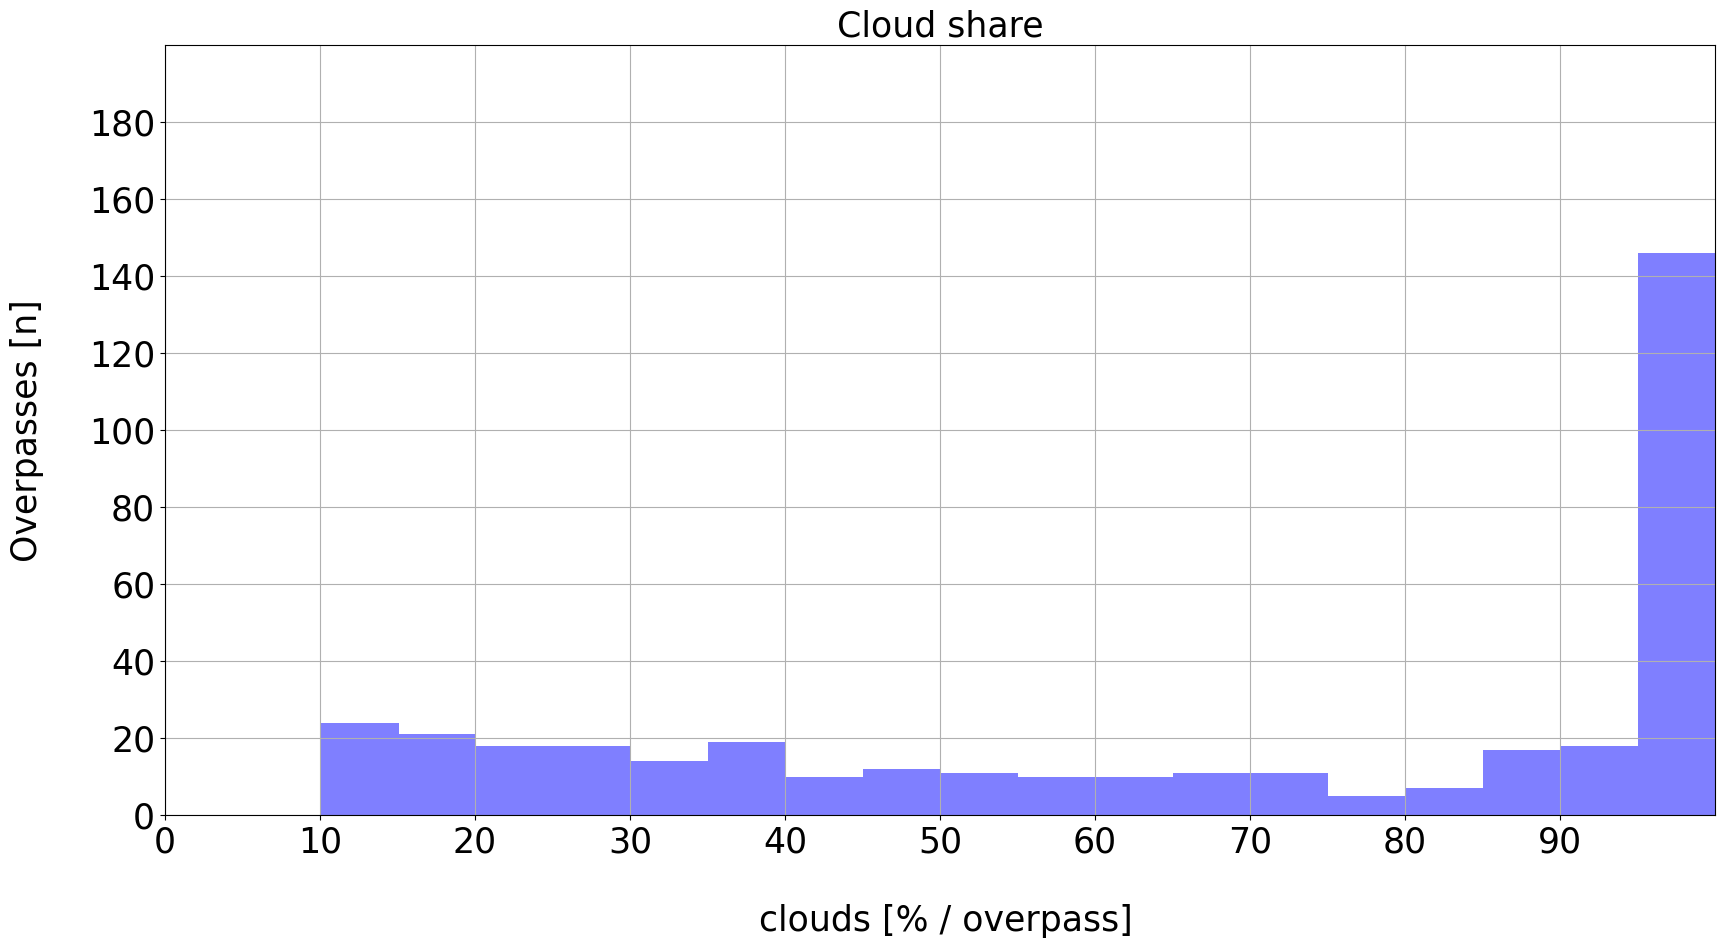

In [40]:
cct = s2_cct

plt.figure(figsize = (20,10))
#plt.scatter(cloud_table["times"].values, cloud_table["clean_percentage"].values)
plt.hist(cct["Cloud free pixel[%]"], 18, facecolor='b', alpha=.5)
plt.title('Cloud share', size='25')
plt.xlabel('\n clouds [% / overpass]', size=25)
plt.ylabel('Overpasses [n]\n', size=25)
plt.yticks(list(range(0,200,20)),size='25')
plt.xticks(list(range(0,100,10)),size='25')
plt.axis([0,100, 0, 200])
plt.grid(True)
#plt.savefig('hist.png')
plt.show()

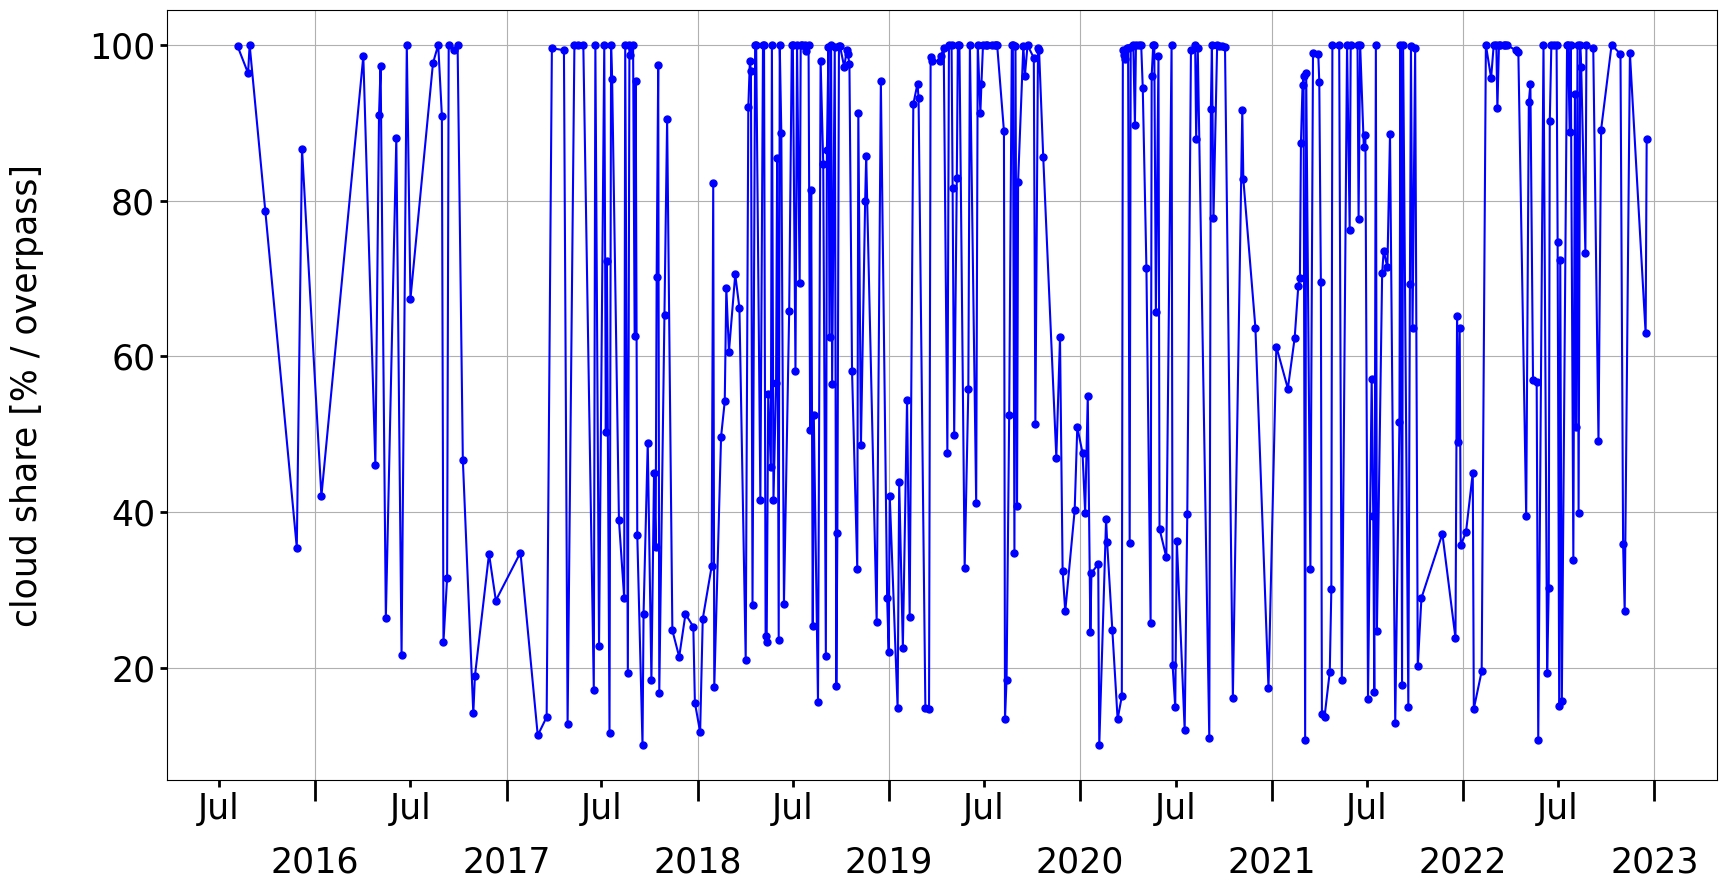

In [19]:
t = cct["Acquisition time"]
pix = cct["Cloud free pixel[%]"].values

fig, ax = plt.subplots(figsize = (20,10))
ax.plot(t,pix,'b-o', markersize=5)

ax.xaxis.set_major_locator(mpl.dates.YearLocator())
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator((7)))

ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("\n%Y"))
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter("%b"))

ax.tick_params(axis='x',which='major', length=15, width=2, labelsize=25)
ax.tick_params(axis='x',which='minor', length=5, width=2, labelsize=25)
ax.tick_params(axis='y',which='major', length=5, width=2, labelsize=25)

plt.grid(True)
plt.ylabel('cloud share [% / overpass]\n', size=25)

plt.savefig('cl_op.png')

plt.show()

## Vegetation analysis
Here different types od vegetation anlysis is visualized, starting with the information on plants health ba the NDVI.

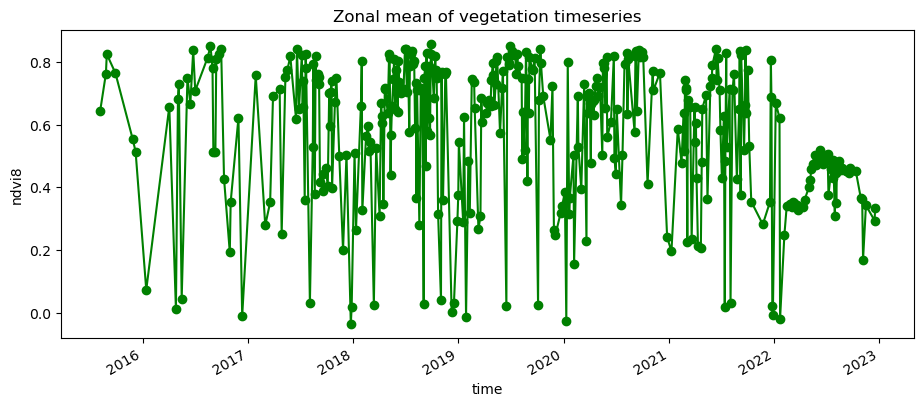

In [20]:
clean_dataset.ndvi8.mean(['x', 'y']).plot.line('g-o', figsize=(11,4))
plt.title('Zonal mean of vegetation timeseries');

In [21]:
# Choose a different resampling period
resample_period='2W'
# Rolling window size for smoothing the curve
window=4
# A vegetation proxy
veg_proxy= 'ndvi8'
# Perform bi-weekly median resampling mean smoothing
veg_smooth=clean_dataset[veg_proxy].resample(time=resample_period).median().rolling(time=window, min_periods=1).mean()

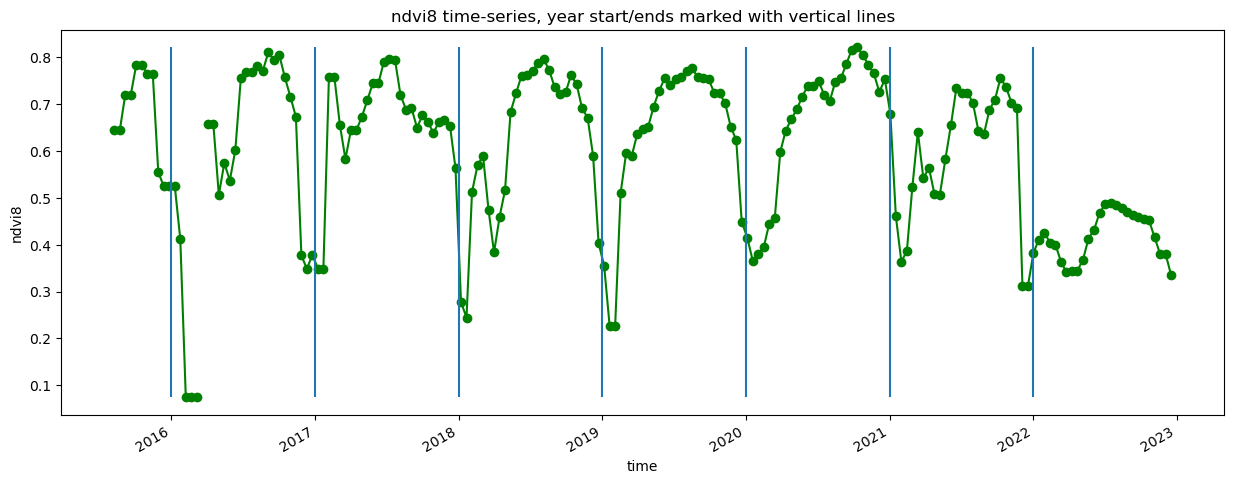

In [22]:
# Calculate zonal mean and plot results
veg_smooth_1D = veg_smooth.mean(['x', 'y'])
veg_smooth_1D.plot.line('g-o', figsize=(15,5))
_max=veg_smooth_1D.max()
_min=veg_smooth_1D.min()

plt.vlines(np.datetime64('2016-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2017-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2018-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2019-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2020-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2021-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2022-01-01'), ymin=_min, ymax=_max)
plt.title(veg_proxy+' time-series, year start/ends marked with vertical lines')
#plt.savefig('ndvi_all') #saving to file
plt.ylabel(veg_proxy);

In [23]:
# MODIFY HERE

# Specify the target aggregation type of the curve fit. 
# Input can be either 'mean' or 'median'.
curve_fit_target = 'median'

# The maximum number of data points that appear along time in each plot.
# If more than this number of data points need to be plotted, a grid of plots will be created.
max_times_per_plot = 50

# Select the binning approach for the vegetation index. Choose one from the list below. 
#  None         = do not bin the data
# 'week'        = bin the data by week with an extended time axis
# 'month'       = bin the data by month with an extended time axis
# 'weekofyear'  = bin the data by week and years using a single year time axis
# 'monthofyear' = bin the data by month and years using a single year time axis
bin_by = 'month'

#### Needed function are under the three dots. Running them may cause view shift.

In [24]:
import time
def xarray_time_series_plot(dataset, plot_descs, x_coord='x',
                            y_coord='y', fig_params=None,
                            fig=None, ax=None, show_legend=True, title=None,
                            max_times_per_plot=None, max_cols=1):
    """
    Plot data variables in an `xarray.Dataset` with different
    plot types and optional curve fits. Handles data binned with
    `xarray.Dataset` methods `resample()` and `groupby()`. That is, it handles data
    binned along time (e.g. by week) or across years (e.g. by week of year).
    Parameters
    -----------
    dataset: xarray.Dataset
        A Dataset containing some bands like NDVI or WOFS.
        It must have time, x, and y coordinates with names specified by
        the 'x_coord' and 'y_coord' parameters.
    plot_descs: dict
        Dictionary mapping names of DataArrays in the Dataset to plot to
        dictionaries mapping aggregation types (e.g. 'mean', 'median') to
        lists of dictionaries mapping plot types
        (e.g. 'line', 'box', 'scatter') to keyword arguments for plotting.
        Aggregation happens within time slices and can be many-to-many or many-to-one.
        Some plot types require many-to-many aggregation (e.g. 'none'), and some other plot types
        require many-to-one aggregation (e.g. 'mean'). Aggregation types can be any of
        ['min', 'mean', 'median', 'none', 'max'], with 'none' performing no aggregation.
        Plot types can be any of
        ['scatter', 'line', 'box', 'gaussian', 'gaussian_filter', 'poly', 'cubic_spline', 'fourier'].
        Here are the required arguments, with format {plot_type: {arg_name: (data_type[, description]}}:
        {'poly': {'degree': (int, "the degree of the polynomial to fit.")}}
        Here are the optional arguments, with format {plot_type: {arg_name: (data_type[, description]}}:
        # See matplotlib.axes.Axes.boxplot() for more information.
        {'box': {'boxprops': dict, 'flierprops': dict, 'showfliers': bool},
        # See gaussian_filter_fit() in data_cube_utilities/curve_fitting.py for more information.
        'gaussian_filter': {'sigma': numeric},
        'fourier':
        {'extrap_time': (string, "a positive integer followed by Y, M, or D -
        year, month, or day - specifying the amount of time to extrapolate over."),
        'extrap_color': (matplotlib color, "a matplotlib color to color the extrapolated data with.")
        }}
        Additionally, all of the curve fits (['gaussian', 'gaussian_filter', 'poly',
        'cubic_spline', 'fourier']) support an optional 'smooth' boolean parameter.
        If true, the curve fit is smoothed, otherwise it will look no smoother than the original data.
        Here is an example:
        {'ndvi':
        {'mean':[{'line':{'color':'forestgreen', 'alpha':alpha}}],
        'none':[{'box':{'boxprops':{'facecolor':'forestgreen','alpha':alpha},'showfliers':False}}]}}
        This example will create a green line plot of the mean of the 'ndvi' band
        as well as a green box plot of the 'ndvi' band.
    x_coord, y_coord: str
        Names of the x and y coordinates in `dataset`.
    fig_params: dict
        Figure parameters dictionary (e.g. {'figsize':(12,6)}). Used to create a Figure
        `if fig is None and ax is None`.
    fig: matplotlib.figure.Figure
        The figure to use for the plot.
        If only `fig` is supplied, the Axes object used will be the first. This
        argument is ignored if ``max_times_per_plot`` is less than the number of times.
    ax: matplotlib.axes.Axes
        The axes to use for the plot. This argument is ignored if
        ``max_times_per_plot`` is less than the number of times.
    show_legend: bool
        Whether or not to show the legend.
    title: str
        The title of each subplot. Note that a date range enclosed in parenthesis
        will be postpended whether this is specified or not.
    max_times_per_plot: int
        The maximum number of times per plot. If specified, multiple plots may be created,
        with each plot having as close to `num_times/max_times_per_plot` number of points
        as possible, where `num_times` is the total number of plotting points, including
        extrapolations. The plots will be arranged in a row-major grid, with the number
        of columns being at most `max_cols`.
    max_cols: int
        The maximum number of columns in the plot grid.
    Returns
    -------
    fig: matplotlib.figure.Figure
        The figure containing the plot grid.
    plotting_data: dict
        A dictionary mapping 3-tuples of data array names, aggregation types, and plot types
        (e.g. ('ndvi', 'none', 'box')) to `xarray.DataArray` objects of the data that was
        plotted for those combinations of aggregation types and plot types.
    Raises
    ------
    ValueError:
        If an aggregation type is not possible for a plot type
    """
    fig_params = {} if fig_params is None else fig_params

    # Lists of plot types that can and cannot accept many-to-one aggregation
    # for each time slice, as well as plot types that support extrapolation.
    plot_types_requiring_aggregation = ['line', 'gaussian', 'gaussian_filter', 'poly',
                                        'cubic_spline', 'fourier']
    plot_types_handling_aggregation = ['scatter'] + plot_types_requiring_aggregation
    plot_types_not_handling_aggregation = ['box']
    plot_types_curve_fit = ['gaussian', 'gaussian_filter', 'poly',
                            'cubic_spline', 'fourier']
    plot_types_supporting_extrapolation = ['fourier']
    all_plot_types = list(set(plot_types_requiring_aggregation + plot_types_handling_aggregation + \
                              plot_types_not_handling_aggregation + plot_types_curve_fit + \
                              plot_types_supporting_extrapolation))

    # Aggregation types that aggregate all values for a given time to one value.
    many_to_one_agg_types = ['min', 'mean', 'median', 'max']
    # Aggregation types that aggregate to many values or do not aggregate.
    many_to_many_agg_types = ['none']
    all_agg_types = many_to_one_agg_types + many_to_many_agg_types

    # Determine how the data was aggregated, if at all.
    possible_time_agg_strs = ['time', 'week', 'month']
    time_agg_str = 'time'
    for possible_time_agg_str in possible_time_agg_strs:
        if possible_time_agg_str in list(dataset.coords):
            time_agg_str = possible_time_agg_str
            break
    # Make the data 2D - time and a stack of all other dimensions.
    all_plotting_data_arrs = list(plot_descs.keys())
    all_plotting_data = dataset[all_plotting_data_arrs]
    all_times = all_plotting_data[time_agg_str].values
    # Mask out times for which no data variable to plot has any non-NaN data.
    nan_mask_data_vars = list(all_plotting_data[all_plotting_data_arrs] \
                              .notnull().data_vars.values())
    for i, data_var in enumerate(nan_mask_data_vars):
        time_nan_mask = data_var if i == 0 else time_nan_mask | data_var
    time_nan_mask = time_nan_mask.any([x_coord, y_coord])
    times_not_all_nan = all_times[time_nan_mask.values]
    non_nan_plotting_data = all_plotting_data.loc[{time_agg_str: times_not_all_nan}]

    # Determine the number of extrapolation data points. #
    extrap_day_range = 0
    n_extrap_pts = 0
    # For each data array to plot...
    for data_arr_name, agg_dict in plot_descs.items():
        # For each aggregation type (e.g. 'mean', 'median')...
        for agg_type, plot_dicts in agg_dict.items():
            # For each plot for this aggregation type...
            for i, plot_dict in enumerate(plot_dicts):
                for plot_type, plot_kwargs in plot_dict.items():
                    # Only check the plot types supporting extrapolation.
                    if plot_type == 'fourier':
                        curr_extrap_day_range = 0
                        n_predict = 0  # Default to no extrapolation.
                        # Addressing this way to modify `plot_descs`.
                        extrap_time = plot_kwargs.get('extrap_time', None)
                        if extrap_time is not None:
                            assert time_agg_str == 'time', \
                                "Extrapolating for data with a time dimension other than 'time' - " \
                                "such as 'month', or 'week' - is not supported. A time dimension of 'month' " \
                                "or 'week' denotes data aggregated for each month or week across years, so " \
                                "extrapolation is meaningless in that case. Support for a time dimension of 'year' " \
                                "has not yet been added."
                            # Determine the number of points to extrapolate (in an approximate manner).
                            # First find the time range of the given data.
                            first_last_days = list(map(lambda np_dt_64: _n64_to_datetime(np_dt_64),
                                                       non_nan_plotting_data.time.values[[0, -1]]))
                            year_range = first_last_days[1].year - first_last_days[0].year
                            month_range = first_last_days[1].month - first_last_days[0].month
                            day_range = first_last_days[1].day - first_last_days[0].day
                            day_range = year_range * 365.25 + month_range * 30 + day_range
                            # Then find the time range of the extrapolation string.
                            fields = re.match(r"(?P<num>[0-9]{0,5})(?P<unit>[YMD])", extrap_time)
                            assert fields is not None, \
                                r"For the '{}' DataArray: When using 'fourier' as " \
                                "the fit type, if the 'extrap_time' parameter is supplied, it must be " \
                                "a string containing a positive integer followed by one of ['Y', 'M', or 'D']." \
                                    .format(data_arr_name)
                            num, unit = int(fields['num']), fields['unit']
                            days_per_unit = dict(Y=365.25, M=30, D=1)[unit]
                            curr_extrap_day_range = num * days_per_unit
                            n_predict = round(len(non_nan_plotting_data[time_agg_str]) *
                                              (curr_extrap_day_range / day_range))
                            plot_descs[data_arr_name][agg_type][i][plot_type] \
                                ['n_predict'] = n_predict
                        # This parameter is used by get_curvefit() later.
                        extrap_day_range = max(extrap_day_range, curr_extrap_day_range)
                        n_extrap_pts = max(n_extrap_pts, n_predict)

    # Collect (1) the times not containing only NaN values and (2) the extrapolation times.
    if time_agg_str == 'time' and len(times_not_all_nan) > 0:
        first_extrap_time = times_not_all_nan[-1] + np.timedelta64(extrap_day_range, 'D') / n_extrap_pts
        last_extrap_time = times_not_all_nan[-1] + np.timedelta64(extrap_day_range, 'D')
        extrap_times = np.linspace(_n64_datetime_to_scalar(first_extrap_time),
                                   _n64_datetime_to_scalar(last_extrap_time), num=n_extrap_pts)
        extrap_times = np.array(list(map(_scalar_to_n64_datetime, extrap_times)))
        times_not_all_nan_and_extrap = np.concatenate((times_not_all_nan, extrap_times)) \
            if len(extrap_times) > 0 else times_not_all_nan
    else:
        times_not_all_nan_and_extrap = times_not_all_nan
    # Compute all of the plotting data - handling aggregations and extrapolations.
    plotting_data_not_nan_and_extrap = {}  # Maps data arary names to plotting data (NumPy arrays).
    # Get the x locations of data points not filled with NaNs and the x locations of extrapolation points.
    epochs = np.array(list(map(n64_to_epoch, times_not_all_nan_and_extrap))) \
        if time_agg_str == 'time' else times_not_all_nan_and_extrap
    epochs_not_extrap = epochs[:len(times_not_all_nan)]

    # Handle aggregations and curve fits. #
    # For each data array to plot...
    for data_arr_name, agg_dict in plot_descs.items():
        data_arr_plotting_data = non_nan_plotting_data[data_arr_name]
        # For each aggregation type (e.g. 'mean', 'median')...
        for agg_type, plot_dicts in agg_dict.items():
            # For each plot for this aggregation type...
            for i, plot_dict in enumerate(plot_dicts):
                for plot_type, plot_kwargs in plot_dict.items():
                    assert plot_type in all_plot_types, \
                        r"For the '{}' DataArray: plot_type '{}' not recognized" \
                            .format(data_arr_name, plot_type)

                    # Ensure aggregation types are legal for this data.
                    # Some plot types require aggregation.
                    if plot_type in plot_types_requiring_aggregation:
                        if agg_type not in many_to_one_agg_types:
                            raise ValueError("For the '{}' DataArray: the plot type "
                                             "'{}' only accepts many-to-one aggregation (currently using '{}'). "
                                             "Please pass any of {} as the aggregation type "
                                             "or change the plot type.".format(data_arr_name, \
                                                                               plot_type, agg_type,
                                                                               many_to_one_agg_types))
                    # Some plot types cannot accept many-to-one aggregation.
                    if plot_type not in plot_types_handling_aggregation:
                        if agg_type not in many_to_many_agg_types:
                            raise ValueError("For the '{}' DataArray: "
                                             "the plot type '{}' only accepts many-to-many aggregation "
                                             "(currently using '{}'). Please pass any of {} as "
                                             "the aggregation type or change the plot type."
                                             .format(data_arr_name, plot_type, agg_type,
                                                     many_to_many_agg_types))

                    # Aggregate if necessary.
                    y = data_arr_plotting_data
                    if agg_type == 'min':
                        y = y.min([x_coord, y_coord])
                    if agg_type == 'mean':
                        y = y.mean([x_coord, y_coord])
                    if agg_type == 'median':
                        y = y.median([x_coord, y_coord])
                    if agg_type == 'max':
                        y = y.max([x_coord, y_coord])

                    # Handle curve fits.
                    if plot_type in plot_types_curve_fit:
                        smooth = plot_kwargs.get('smooth', True)
                        # Create the curve fit.
                        x_smooth = None if smooth else epochs_not_extrap
                        data_arr_epochs, y = get_curvefit(epochs_not_extrap, y.values, fit_type=plot_type,
                                                          x_smooth=x_smooth, fit_kwargs=plot_kwargs)
                        # Convert time stamps to NumPy datetime objects.
                        data_arr_times = np.array(list(map(_scalar_to_n64_datetime, data_arr_epochs))) \
                            if time_agg_str == 'time' else data_arr_epochs
                        # Convert the NumPy array into an xarray DataArray.
                        coords = {time_agg_str: data_arr_times}
                        dims = list(coords.keys())
                        y = xr.DataArray(y, coords=coords, dims=dims)
                    plotting_data_not_nan_and_extrap[(data_arr_name, agg_type, plot_type)] = y

    # Handle the potential for multiple plots.
    max_times_per_plot = len(times_not_all_nan_and_extrap) if max_times_per_plot is None else \
        max_times_per_plot
    num_times = len(times_not_all_nan_and_extrap)
    num_plots = int(np.ceil(num_times / max_times_per_plot))
    num_times_per_plot = round(num_times / num_plots) if num_plots != 0 else 0
    num_cols = min(num_plots, max_cols)
    num_rows = int(np.ceil(num_plots / num_cols)) if num_cols != 0 else 0
    # Set a reasonable figsize if one is not set in `fig_params`.
    fig_params.setdefault('figsize', (12 * num_cols, 6 * num_rows))
    fig = plt.figure(**fig_params) if fig is None else fig

    # Check if there are no plots to make.
    if num_plots == 0:
        return fig, plotting_data_not_nan_and_extrap

    # Create each plot. #
    for time_ind, ax_ind in zip(range(0, len(times_not_all_nan_and_extrap), num_times_per_plot),
                                range(num_plots)):
        # The time bounds of this canvas (or "Axes object" or "plot grid cell").
        ax_lower_time_bound_ind, ax_upper_time_bound_ind = \
            time_ind, min(time_ind + num_times_per_plot, len(times_not_all_nan_and_extrap))
        # Retrieve or create the axes if necessary.
        if len(times_not_all_nan_and_extrap) <= num_times_per_plot:
            fig, ax = retrieve_or_create_fig_ax(fig, ax, **fig_params)
        else:
            ax = fig.add_subplot(num_rows, num_cols, ax_ind + 1)
        ax_times_not_all_nan_and_extrap = \
            times_not_all_nan_and_extrap[ax_lower_time_bound_ind:ax_upper_time_bound_ind]
        ax_time_bounds = ax_times_not_all_nan_and_extrap[[0, -1]]
        ax_epochs = epochs[ax_lower_time_bound_ind:ax_upper_time_bound_ind]
        ax_x_locs = np_scale(ax_epochs if time_agg_str == 'time' else ax_times_not_all_nan_and_extrap)

        # Data variable plots within each plot.
        data_arr_plots = []
        legend_labels = []
        # For each data array to plot...
        for data_arr_name, agg_dict in plot_descs.items():
            # For each aggregation type (e.g. 'mean', 'median')...
            for agg_type, plot_dicts in agg_dict.items():
                # For each plot for this aggregation type...
                for plot_dict in plot_dicts:
                    for plot_type, plot_kwargs in plot_dict.items():
                        # Determine the legend label for this plot.
                        plot_type_str = \
                            {'scatter': 'scatterplot', 'line': 'lineplot',
                             'box': 'boxplot', 'gaussian': 'gaussian fit',
                             'gaussian_filter': 'gaussian filter fit',
                             'poly': 'degree {} polynomial fit',
                             'cubic_spline': 'cubic spline fit',
                             'fourier': 'Fourier fit ({} harmonics)'}[plot_type]
                        if plot_type == 'poly':
                            assert 'degree' in plot_kwargs, \
                                r"For the '{}' DataArray: When using 'poly' as " \
                                "the fit type, the fit kwargs must have 'degree' " \
                                "specified.".format(data_arr_name)
                            plot_type_str = plot_type_str.format(
                                plot_kwargs.get('degree'))
                        if plot_type == 'fourier':
                            plot_type_str = plot_type_str.format(
                                plot_kwargs.get('n_harm', default_fourier_n_harm))
                        # Legend labels for the non-extrapolation
                        # and extrapolation segments
                        plot_type_strs = []

                        # Remove plot kwargs that are not recognized
                        # by plotting methods (cause errors).
                        plot_kwargs = plot_kwargs.copy()
                        plot_kwargs.pop('extrap_time', None)
                        plot_kwargs.pop('n_predict', None)
                        plot_kwargs.pop('smooth', None)
                        plot_kwargs.pop('degree', None)  # 'degree'
                        plot_kwargs.pop('n_harm', None)  # 'fourier'

                        # Handle default plot kwargs.
                        if plot_type == 'box':
                            plot_kwargs.setdefault('boxprops',
                                                   dict(facecolor='orange'))
                            plot_kwargs.setdefault('flierprops',
                                                   dict(marker='o', markersize=0.5))
                            plot_kwargs.setdefault('showfliers', False)

                        # Retrieve the plotting data.
                        y = plotting_data_not_nan_and_extrap[
                            (data_arr_name, agg_type, plot_type)]
                        y = y.sel({time_agg_str:
                                       slice(ax_time_bounds[0], ax_time_bounds[1])})

                        # Handle cases of insufficient data for this section of the plot.
                        not_nat_times = None
                        if time_agg_str == 'time':
                            not_nat_times = ~np.isnat(y[time_agg_str].values)
                        else:
                            not_nat_times = ~np.isnan(y[time_agg_str].values)
                        num_unique_times_y = len(np.unique(y[time_agg_str].values[not_nat_times]))
                        if num_unique_times_y == 0:  # There is no data.
                            continue
                        if num_unique_times_y == 1:  # There is 1 data point.
                            plot_type = 'scatter'
                            plot_kwargs = {}

                        data_arr_epochs = \
                            np.array(list(map(n64_to_epoch, y[time_agg_str].values))) \
                                if time_agg_str == 'time' else \
                                ax_times_not_all_nan_and_extrap
                        data_arr_x_locs = np.interp(data_arr_epochs,
                                                    ax_epochs, ax_x_locs)
                        data_arr_time_bounds = y[time_agg_str].values[[0, -1]]

                        # Determine if this plotting data includes extrapolated values.
                        data_arr_non_extrap_time_bounds = None
                        data_arr_has_non_extrap = \
                            data_arr_time_bounds[0] < times_not_all_nan[-1]
                        if data_arr_has_non_extrap:
                            data_arr_non_extrap_time_bounds = \
                                [data_arr_time_bounds[0], min(data_arr_time_bounds[1],
                                                              times_not_all_nan[-1])]
                            # Because the data could be smoothed, the last
                            # non-extrapolation time is the last time before
                            # or at the last non-extrapolation time
                            # for the original data.
                            non_extrap_plot_last_time = data_arr_non_extrap_time_bounds[1]
                            if num_unique_times_y > 1:
                                non_extrap_plot_last_time = \
                                    y.sel({time_agg_str: data_arr_non_extrap_time_bounds[1]},
                                          method='ffill')[time_agg_str].values
                            data_arr_non_extrap_plotting_time_bounds = [data_arr_non_extrap_time_bounds[0],
                                                                        non_extrap_plot_last_time]

                        data_arr_extrap_time_bounds = None
                        data_arr_has_extrap = times_not_all_nan[-1] < data_arr_time_bounds[1]
                        if data_arr_has_extrap:
                            data_arr_extrap_time_bounds = [max(data_arr_time_bounds[0],
                                                               extrap_times[0]),
                                                           data_arr_time_bounds[1]]
                            # Because the data could be smoothed, the first extrapolation time
                            # is the first time after the last non-extrapolation time for the original data.
                            extrap_plot_first_time = \
                                y.sel({time_agg_str: data_arr_non_extrap_time_bounds[1]},
                                      method='ffill')[time_agg_str].values \
                                    if data_arr_has_non_extrap else \
                                    data_arr_time_bounds[0]
                            data_arr_extrap_plotting_time_bounds = [extrap_plot_first_time,
                                                                    data_arr_extrap_time_bounds[1]]

                        # Separate non-extrapolation and extrapolation data.
                        if data_arr_has_non_extrap:
                            data_arr_non_extrap = \
                                y.sel({time_agg_str: slice(*data_arr_non_extrap_plotting_time_bounds)})
                            data_arr_non_extrap_epochs = \
                                np.array(list(map(n64_to_epoch, data_arr_non_extrap[time_agg_str].values))) \
                                    if time_agg_str == 'time' else data_arr_non_extrap[time_agg_str].values
                            data_arr_non_extrap_x_locs = \
                                np.interp(data_arr_non_extrap_epochs, ax_epochs, ax_x_locs)
                            # Format plotting kwargs for the non-extrapolation data.
                            plot_kwargs_non_extrap = plot_kwargs.copy()
                            plot_kwargs_non_extrap.pop('extrap_color', None)
                        if data_arr_has_extrap:
                            # Include the last non-extrapolation point so the
                            # non-extrapolation and extrapolation lines connect.
                            data_arr_extrap = \
                                y.sel({time_agg_str: slice(*data_arr_extrap_plotting_time_bounds)})
                            data_arr_extrap_epochs = \
                                np.array(list(map(n64_to_epoch, data_arr_extrap[time_agg_str].values))) \
                                    if time_agg_str == 'time' else data_arr_extrap[time_agg_str].values
                            data_arr_extrap_x_locs = \
                                np.interp(data_arr_extrap_epochs, ax_epochs, ax_x_locs)
                            # Format plotting kwargs for the extrapolation data.
                            plot_kwargs_extrap = plot_kwargs.copy()
                            extrap_color = plot_kwargs_extrap.pop('extrap_color', None)
                            if extrap_color is not None:
                                plot_kwargs_extrap['color'] = extrap_color

                        # Specify non-extrap and extrap plotting args.
                        if data_arr_has_non_extrap:
                            plot_args_non_extrap = \
                                [data_arr_non_extrap_x_locs, data_arr_non_extrap]
                        if data_arr_has_extrap:
                            plot_args_extrap = \
                                [data_arr_extrap_x_locs, data_arr_extrap]

                        # Actually create the plot.
                        def create_plot(x_locs, data_arr, **plot_kwargs):
                            """
                            Creates a plot
                            Parameters
                            ----------
                            x_locs: xarray.DataArray
                                A 1D `xarray.DataArray` containing ascending values
                                in range [0,1], denoting the x locations on the current
                                canvas at which to plot data with corresponding time
                                indicies in `data_arr`.
                            data_arr: xarray.DataArray
                                An `xarray.DataArray` containing a dimension named
                                `time_agg_str` (the value of that variable in this context).
                            Returns
                            -------
                            plot_obj: matplotlib.artist.Artist
                                The plot.
                            """
                            plot_obj = None
                            if plot_type == 'scatter':
                                data_arr_dims = list(data_arr.dims)
                                data_arr_flat = data_arr.stack(flat=data_arr_dims)
                                plot_obj = ax.scatter(x_locs, data_arr_flat)
                            elif plot_type in ['line', 'gaussian', 'gaussian_filter',
                                               'poly', 'cubic_spline', 'fourier']:
                                plot_obj = ax.plot(x_locs, data_arr)[0]
                            elif plot_type == 'box':
                                boxplot_nan_mask = ~np.isnan(data_arr)
                                # Data formatted for matplotlib.pyplot.boxplot().
                                filtered_formatted_data = []
                                for i, (d, m) in enumerate(zip(data_arr.values,
                                                               boxplot_nan_mask.values)):
                                    if len(d[m] != 0):
                                        filtered_formatted_data.append(d[m])
                                box_width = 0.5 * np.min(np.diff(x_locs)) \
                                    if len(x_locs) > 1 else 0.5
                                # `manage_ticks=False` to avoid excessive padding on x-axis.
                                bp = ax.boxplot(filtered_formatted_data,
                                                widths=[box_width] * len(filtered_formatted_data),
                                                positions=x_locs, patch_artist=True,
                                                manage_ticks=False, **plot_kwargs)
                                plot_obj = bp['boxes'][0]
                            return plot_obj

                        if data_arr_has_non_extrap:
                            plot_obj = create_plot(*plot_args_non_extrap, **plot_kwargs_non_extrap)
                            data_arr_plots.append(plot_obj)
                            plot_type_strs.append(plot_type_str)
                        if data_arr_has_extrap and plot_type in plot_types_supporting_extrapolation:
                            plot_obj = create_plot(*plot_args_extrap, **plot_kwargs_extrap)
                            data_arr_plots.append(plot_obj)
                            plot_type_strs.append('extrapolation of ' + plot_type_str)
                        plot_type_str_suffix = ' of {}'.format(agg_type) if agg_type != 'none' else ''
                        plot_type_strs = [plot_type_str + plot_type_str_suffix
                                          for plot_type_str in plot_type_strs]
                        [legend_labels.append('{} of {}'.format(plot_type_str, data_arr_name))
                         for plot_type_str in plot_type_strs]

        # Label the axes and create the legend.
        date_strs = \
            np.array(list(map(lambda time: np_dt64_to_str(time), ax_times_not_all_nan_and_extrap))) \
                if time_agg_str == 'time' else \
                naive_months_ticks_by_week(ax_times_not_all_nan_and_extrap) \
                    if time_agg_str in ['week', 'weekofyear'] else \
                    month_ints_to_month_names(ax_times_not_all_nan_and_extrap)
        plt.xticks(ax_x_locs, date_strs, rotation=45, ha='right', rotation_mode='anchor')
        if show_legend:
            ax.legend(handles=data_arr_plots, labels=legend_labels, loc='best')
        title_postpend = " ({} to {})".format(date_strs[0], date_strs[-1])
        title_prepend = "Figure {}".format(ax_ind) if title is None else title
        ax.set_title(title_prepend + title_postpend)
    return fig, plotting_data_not_nan_and_extrap

In [25]:
def _scalar_to_n64_datetime(scalar):
    """
    Converts a floating point number to a NumPy datetime64 object.
    
    Returns
    -------
    dt64: numpy.datetime64
        The NumPy datetime64 object representing the datetime of the scalar argument.
    """
    return (scalar * np.timedelta64(1, 's')) + np.datetime64('1970-01-01T00:00:00Z')

In [26]:
def _n64_datetime_to_scalar(dt64):
    """
    Converts a NumPy datetime64 object to the number of seconds since 
    midnight, January 1, 1970, as a NumPy float64.
    
    Returns
    -------
    scalar: numpy.float64
        The number of seconds since midnight, January 1, 1970, as a NumPy float64.
    """
    return (dt64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')

In [27]:
def n64_to_epoch(timestamp):
    ts = pd.to_datetime(str(timestamp))
    time_format = "%Y-%m-%d"
    ts = ts.strftime(time_format)
    epoch = int(time.mktime(time.strptime(ts, time_format)))
    return epoch

In [28]:
def get_curvefit(x, y, fit_type, x_smooth=None, n_pts=2000, fit_kwargs=None):
    """
    Gets a curve fit given x values, y values, a type of curve, and parameters for that curve.
    Parameters
    ----------
    x: np.ndarray
        A 1D NumPy array. The x values to fit to.
    y: np.ndarray
        A 1D NumPy array. The y values to fit to.
    fit_type: str
        The type of curve to fit. One of 
        ['gaussian', 'gaussian_filter', 'poly', 
        'cubic_spline', 'fourier'].
        The option 'gaussian' creates a Gaussian fit.
        The option 'gaussian_filter' creates a Gaussian filter fit.
        The option 'poly' creates a polynomial fit.
        The option 'cubic_spline' creates a cubic spline fit.
        The option 'fourier' creates a Fourier curve fit.
    x_smooth: list-like
        The exact x values to interpolate for. Supercedes `n_pts`.
    n_pts: int
        The number of evenly spaced points spanning the range of `x` to interpolate for.
    fit_kwargs: dict
        Keyword arguments for the selected fit type.
        In the case of `fit_type == 'poly'`, this must contain a 'degree' entry (an int),
        which is the degree of the polynomial to fit.
        In the case of `fit_type == 'gaussian_filter'`, this may contain a 'sigma' entry,
        which is the standard deviation of the Gaussian kernel.
        A larger value yields a smoother but less close-fitting curve.
        In the case of `fit_type == 'fourier'`, this may contain 'n_predict' or 'n_harm' entries.
        The 'n_predict' entry is the number of points to extrapolate.
        The points will be spaced evenly by the mean spacing of values in `x`.
        The 'n_harm' entry is the number of harmonics to use.
        A higher value yields a closer fit.
    Returns
    -------
    x_smooth, y_smooth: numpy.ndarray
        The smoothed x and y values of the curve fit.
        If there are no non-NaN values in `y`, these will be filled with `n_pts` NaNs.
        If there is only 1 non-NaN value in `y`, these will be filled with
        their corresponding values (y or x value) for that point to a length of `n_pts`.
    """
    from scipy.interpolate import CubicSpline
    #from .curve_fitting import gaussian_fit, gaussian_filter_fit, poly_fit, fourier_fit

    interpolation_curve_fits = ['gaussian', 'gaussian_filter',
                                'poly', 'cubic_spline']
    extrapolation_curve_filts = ['fourier']
    # Handle NaNs (omit them).
    not_nan_mask = ~np.isnan(y)
    x = x[not_nan_mask]; y = y[not_nan_mask]

    # Handle the cases of there being too few points to curve fit.
    if len(y) == 0:
        x_smooth = np.repeat(np.nan, n_pts)
        y_smooth = np.repeat(np.nan, n_pts)
        return x_smooth, y_smooth
    if len(y) == 1:
        x_smooth = np.repeat(x[0], n_pts)
        y_smooth = np.repeat(y[0], n_pts)
        return x_smooth, y_smooth

    if x_smooth is None:
        x_smooth_inds = np.linspace(0, len(x) - 1, n_pts)
        x_smooth = np.interp(x_smooth_inds, np.arange(len(x)), x)

    opt_params = {}
    if fit_type == 'gaussian':
        x_smooth, y_smooth = gaussian_fit(x, y, x_smooth)
    elif fit_type == 'gaussian_filter':
        if 'sigma' in fit_kwargs:
            opt_params.update(dict(sigma=fit_kwargs.get('sigma')))
        x_smooth, y_smooth = gaussian_filter_fit(x, y, x_smooth,
                                                 **opt_params)
    elif fit_type == 'poly':
        assert 'degree' in fit_kwargs.keys(), \
            "When plotting a polynomal fit, there must be" \
            "a 'degree' entry in the plot_kwargs parameter."
        degree = fit_kwargs.get('degree')
        x_smooth, y_smooth = poly_fit(x, y, degree, x_smooth)
    elif fit_type == 'cubic_spline':
        cs = CubicSpline(x, y)
        y_smooth = cs(x_smooth)
    if fit_type in extrapolation_curve_filts:
        n_predict = fit_kwargs.get('n_predict', 0)
        if fit_type == 'fourier':
            if 'n_harm' in fit_kwargs:
                opt_params.update(dict(n_harm=fit_kwargs.get('n_harm')))
            x_smooth, y_smooth = \
                fourier_fit(x, y, n_predict, x_smooth,
                            **opt_params)
    return x_smooth, y_smooth

In [29]:
def gaussian_filter_fit(x, y, x_smooth=None, n_pts=2000, sigma=0.75):
    """
    Fits a Gaussian filter to some data - x and y. Returns predicted interpolation values.
    Currently, smoothing is achieved by fitting a cubic spline to the gaussian filter fit
    of `x` and `y`.
    Parameters
    ----------
    x: list-like
        The x values of the data to fit to.
    y: list-like
        The y values of the data to fit to.
    x_smooth: list-like, optional
        The exact x values to interpolate for. Supercedes `n_pts`.
    n_pts: int, optional
        The number of evenly spaced points spanning the range of `x` to interpolate for.
    sigma: numeric, optional
        The standard deviation of the Gaussian kernel. A larger value yields a smoother curve,
        but also reduced the closeness of the fit. By default, it is `0.75`.
    Returns
    -------
    x_smooth, y_smooth: numpy.ndarray
        The smoothed x and y values of the curve fit.
    """
    from scipy.interpolate import CubicSpline
    from scipy.ndimage.filters import gaussian_filter1d

    if x_smooth is None:
        x_smooth_inds = np.linspace(0, len(x)-1, n_pts)
        x_smooth = np.interp(x_smooth_inds, np.arange(len(x)), x)
    gauss_filter_y = gaussian_filter1d(y, sigma)
    cs = CubicSpline(x, gauss_filter_y)
    y_smooth = cs(x_smooth)
    return x_smooth, y_smooth

In [30]:
def np_scale(arr, pop_arr=None, pop_min_max=None, pop_mean_std=None, min_max=None, scaling='norm'):
    """
    Scales a NumPy array with standard scaling or norm scaling, default to norm scaling.
    Parameters
    ----------
    arr: numpy.ndarray
        The NumPy array to scale.
    pop_arr: numpy.ndarray, optional
        The NumPy array to treat as the population.
        If specified, all members of `arr` must be within the range of `pop_arr`
        or `min_max` must be specified.
    pop_min_max: list-like, optional
        The population minimum and maximum, in that order.
        Supercedes `pop_arr` when normalizing.
    pop_mean_std: list-like, optional
        The population mean and standard deviation, in that order.
        Supercedes `pop_arr` when standard scaling.
    min_max: list-like, optional
        The desired minimum and maximum of the final output, in that order.
        If all values are the same, all values will become `min_max[0]`.
    scaling: str, optional
        The options are ['std', 'norm'].
        The option 'std' standardizes. The option 'norm' normalizes (min-max scales).
    """
    if len(arr) == 0:
        return arr
    pop_arr = arr if pop_arr is None else pop_arr
    if scaling == 'norm':
        pop_min, pop_max = (pop_min_max[0], pop_min_max[1]) if pop_min_max is not None \
            else (np.nanmin(pop_arr), np.nanmax(pop_arr))
        numerator, denominator = arr - pop_min, pop_max - pop_min
    elif scaling == 'std':
        mean, std = pop_mean_std if pop_mean_std is not None else (np.nanmean(pop_arr), np.nanstd(pop_arr))
        numerator, denominator = arr - mean, std
    # Primary scaling
    new_arr = arr
    if denominator > 0:
        new_arr = numerator / denominator
    # Optional final scaling.
    if min_max is not None:
        if denominator > 0:
            new_arr = np.interp(new_arr, (np.nanmin(new_arr), np.nanmax(new_arr)), min_max)
        else: # The values are identical - set all values to the low end of the desired range.
            new_arr = np.full_like(new_arr, min_max[0])
    return new_arr

In [31]:
def np_dt64_to_str(np_datetime, fmt='%Y-%m-%d'):
    """Converts a NumPy datetime64 object to a string based on a format string supplied to pandas strftime."""
    return pd.to_datetime(str(np_datetime)).strftime(fmt)

### Here we visualize a smoothed curve with a spread of the data in boxplots

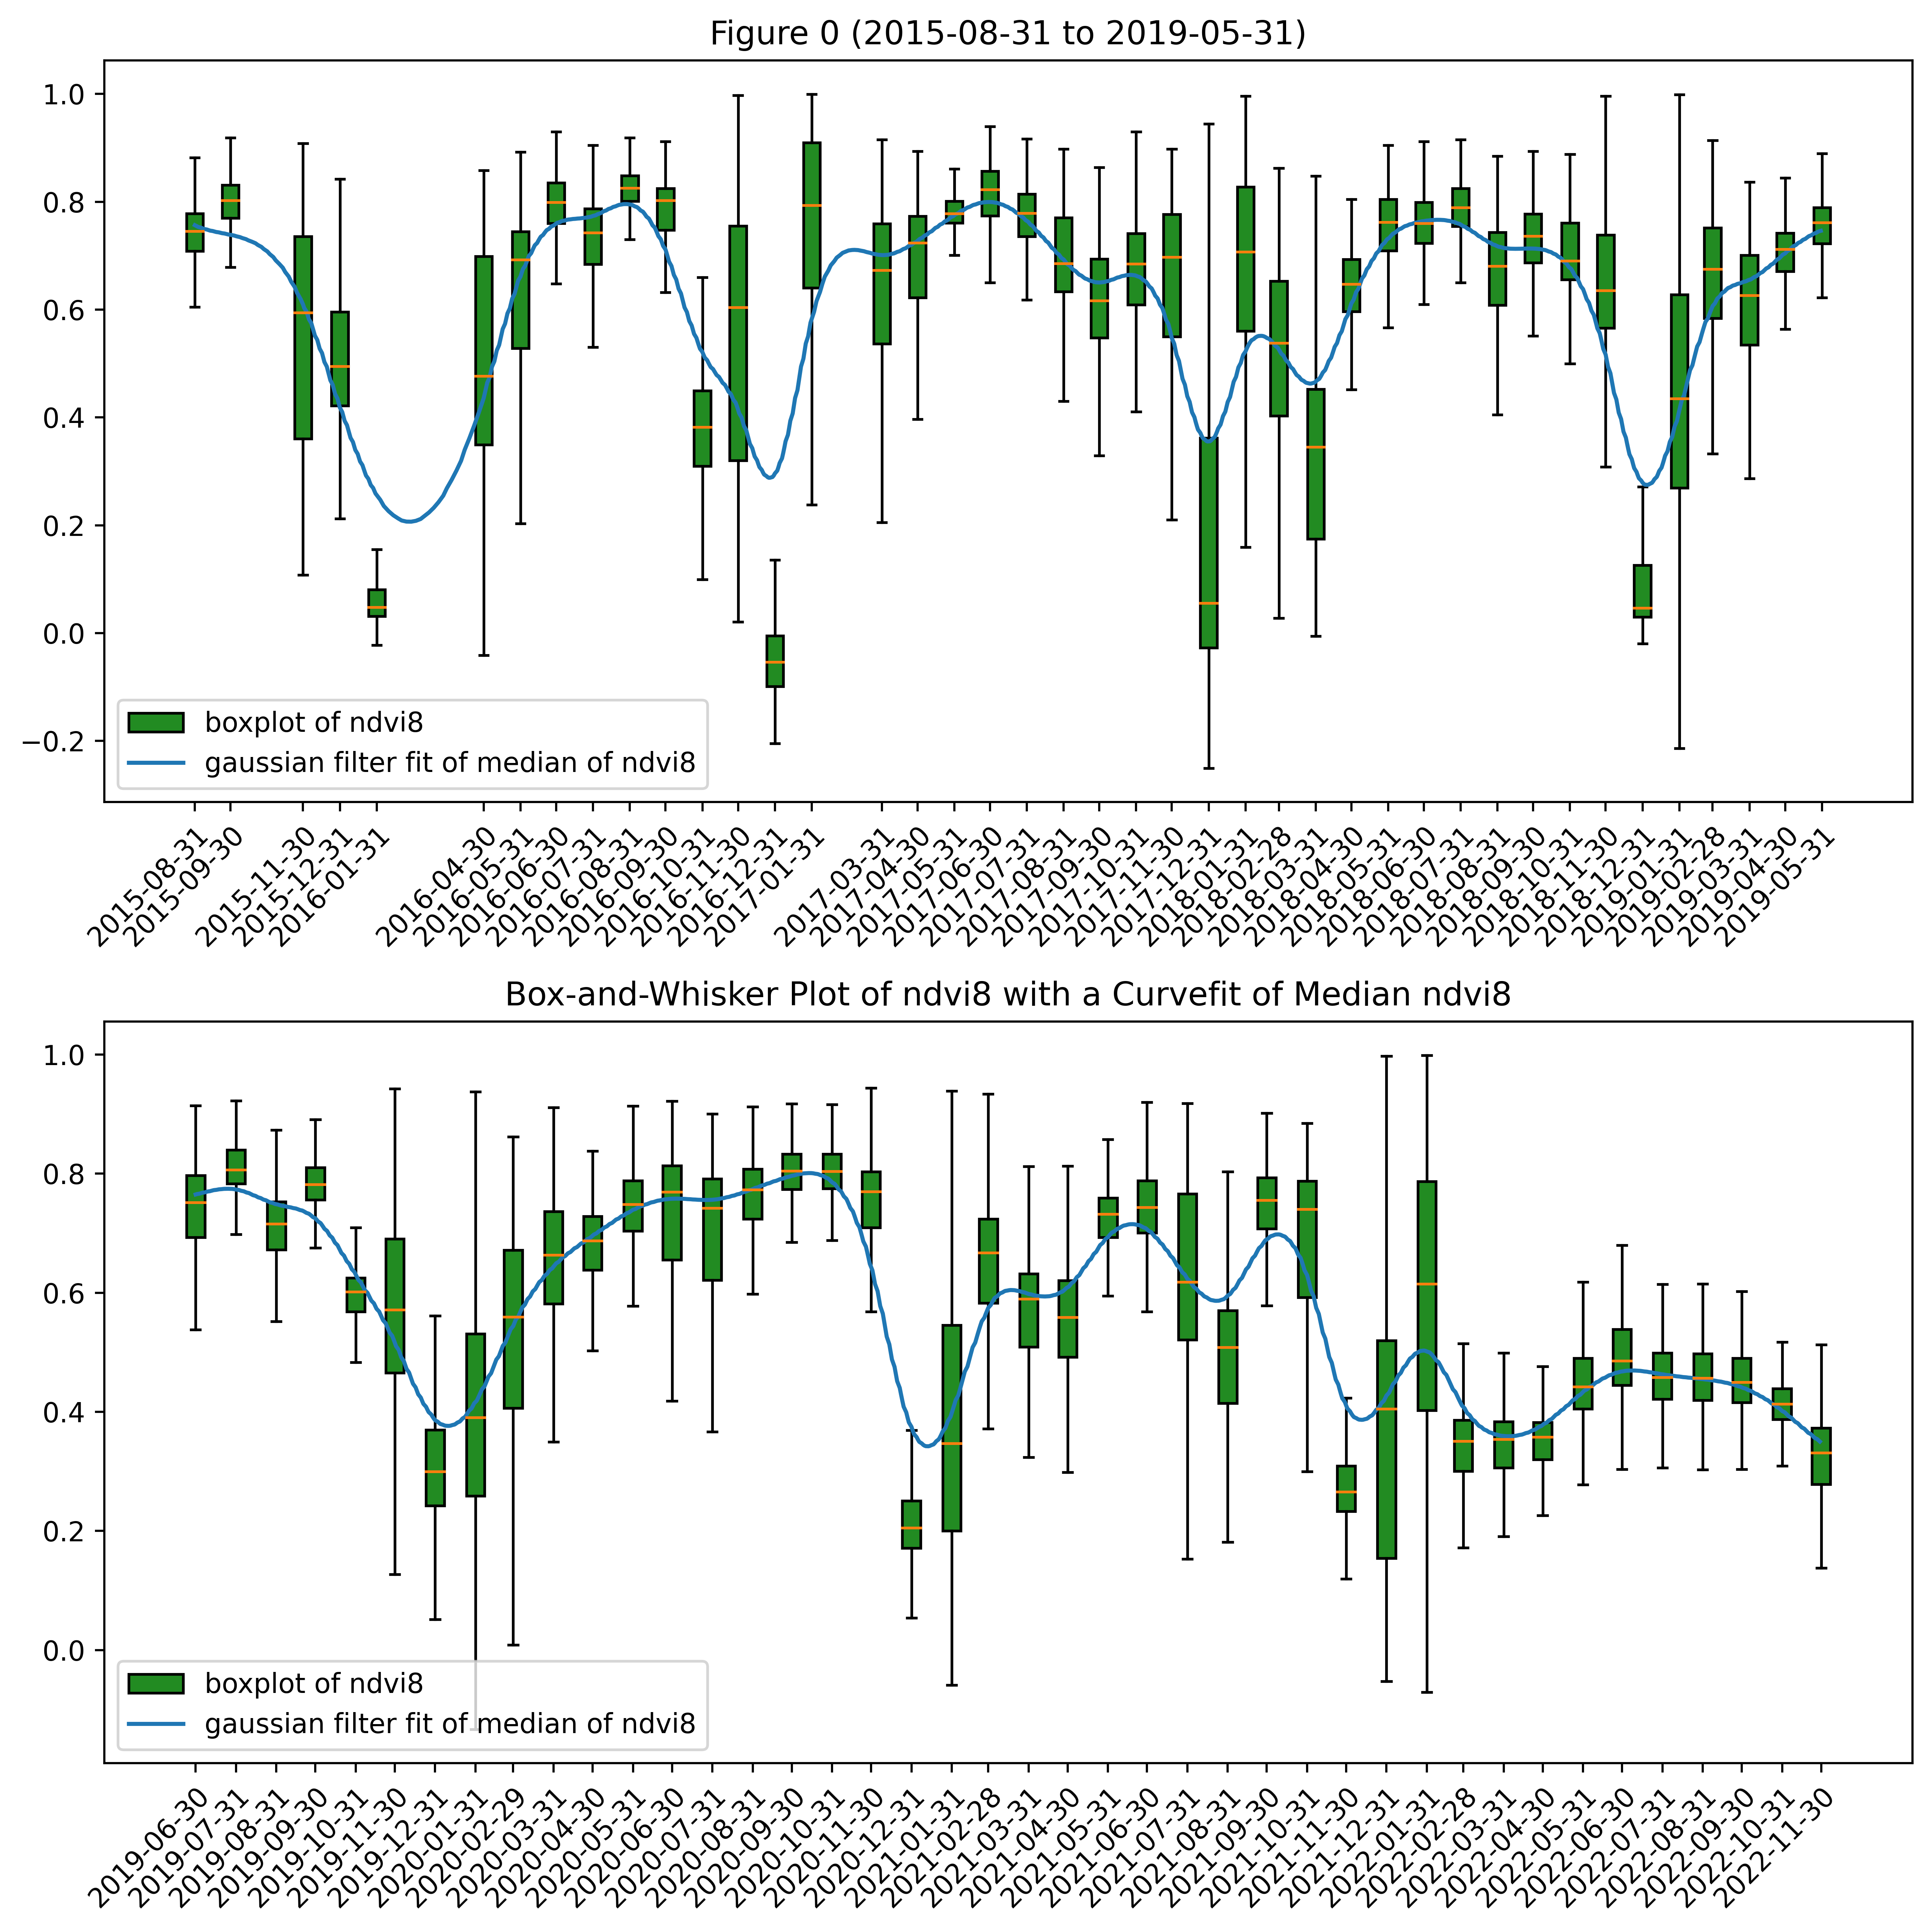

In [32]:
#@title Create NDVI Boxplot
time_extents = ('2015-07-01', '2022-12-31')
bin_by = 'month'
veg_proxy = 'ndvi8'

aggregated_by_str = None
if bin_by is None:
    plotting_data = clean_dataset
elif bin_by == 'week':
    plotting_data = clean_dataset.resample(time='1w').mean()
    aggregated_by_str = 'Week'
elif bin_by == 'month':
    plotting_data = clean_dataset.resample(time='1m').mean()
    aggregated_by_str = 'Month'
elif bin_by == 'weekofyear':
    plotting_data = clean_dataset.groupby('time.week').mean(dim=('time'))
    aggregated_by_str = 'Week of Year'
elif bin_by == 'monthofyear':
    plotting_data = clean_dataset.groupby('time.month').mean(dim=('time'))
    aggregated_by_str = 'Month of Year'
    
params = dict(dataset=plotting_data, plot_descs={veg_proxy:{'none':[
    {'box':{'boxprops':{'facecolor':'forestgreen'}}}]}})
#change 
params['plot_descs'][veg_proxy][curve_fit_target] = [{'gaussian_filter':{}}]
    
fig, curve_fit_plotting_data = \
    xarray_time_series_plot(**params, fig_params=dict(figsize=(10,10), dpi=520), 
                            max_times_per_plot=max_times_per_plot)

plt.title('Box-and-Whisker Plot of {1} with a Curvefit of {0} {1}'
          .format(curve_fit_target.capitalize(), veg_proxy))
plt.tight_layout()
#plt.savefig('ndvi8_gauss') #saving to file
plt.show()


### Load needed functions

In [33]:
bin_by = 'monthofyear'
years_with_data = []
daysofyear_per_year = {}
plotting_data_years = {}
plot_descs = {}

for year in range(np.datetime64(time_extents[0], 'Y').item().year,
                  np.datetime64(time_extents[1], 'Y').item().year+1):
    year_data = clean_dataset.sel(time=slice('{}-01-01'.format(year), '{}-12-31'.format(year)))[veg_proxy]
    if len(year_data['time']) == 0: # There is nothing to plot for this year.
        print("Year {} has no data, so will not be plotted.".format(year))
        continue
    years_with_data.append(year)
    spec_ind_dayofyear = year_data.groupby('time.dayofyear').mean()
    daysofyear_per_year[year] = spec_ind_dayofyear[~spec_ind_dayofyear.isnull().sum(dim='dayofyear')].dayofyear
    aggregated_by_str = None
    if bin_by == 'weekofyear':
        plotting_data_year = year_data.groupby('time.week').mean(dim=('time'))
        time_dim_name = 'week'
    elif bin_by == 'monthofyear':
        plotting_data_year = year_data.groupby('time.month').mean(dim=('time'))
        time_dim_name = 'month'

    plotting_data_years[year] = plotting_data_year
    num_time_pts = len(plotting_data_year[time_dim_name])
    
    # Select the curve-fit type. 
    # See the documentation for `xarray_time_series_plot()` regarding the `plot_descs` parameter.
    plot_descs[year] = {'mean':[{'gaussian_filter':{}}]}
    
def retrieve_or_create_fig_ax(fig=None, ax=None, **subplots_kwargs):
    """
    Returns appropriate matplotlib Figure and Axes objects given Figure and/or Axes objects.
    If neither is supplied, a new figure will be created with associated axes.
    If only `fig` is supplied, `(fig,fig.axes[0])` is returned. That is, the first Axes object will be used (and created if necessary).
    If `ax` is supplied, `(fig, ax)` is returned.
    Returns
    -------
    fig, ax: matplotlib.figure.Figure, matplotlib.axes.Axes
        The figure and the axes of that figure.
    **subplots_kwargs: dict
        A dictionary of keyword arguments to passed to `matplotlib.pyplot.subplots()`,
        such as `ncols` or `figsize`.
    """
    if ax is None:
        if fig is None:
            fig, ax = plt.subplots(**subplots_kwargs)
        else:
            if len(fig.axes) == 0:
                fig.add_subplot(111)
            ax = fig.axes[0]
    return fig, ax

def month_ints_to_month_names(month_ints):
    """
    Converts ordinal numbers for months (in range [1,12]) to their 3-letter names.
    """
    return [month_names_short[i - 1] for i in month_ints]

month_names_short = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

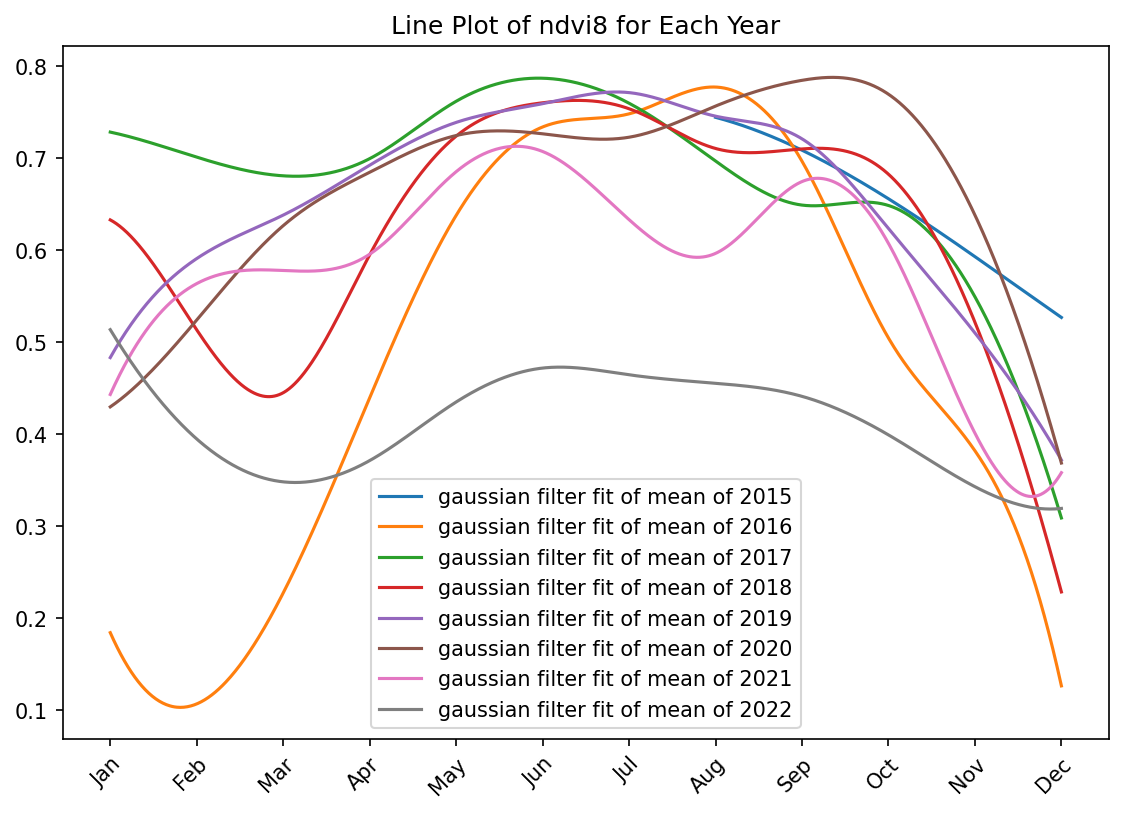

In [34]:
# Annual seasonal curve calculation
years_with_data = []
plot_descs = {}
daysofyear_per_year = {}
plotting_data_years = {}
time_dim_name = None
for year in range(np.datetime64(time_extents[0], 'Y').item().year,
                  np.datetime64(time_extents[1], 'Y').item().year+1):
    year_data = clean_dataset.sel(time=slice('{}-01-01'.format(year), '{}-12-31'.format(year)))[veg_proxy]
    if len(year_data['time']) == 0: # There is nothing to plot for this year.
        print("Year {} has no data, so will not be plotted.".format(year))
        continue
    years_with_data.append(year)
    
    spec_ind_dayofyear = year_data.groupby('time.dayofyear').mean()
    daysofyear_per_year[year] = spec_ind_dayofyear[~spec_ind_dayofyear.isnull().sum(dim='dayofyear')].dayofyear
    
    aggregated_by_str = None
    if bin_by == 'weekofyear':
        plotting_data_year = year_data.groupby('time.week').mean(dim=('time'))
        time_dim_name = 'week'
    elif bin_by == 'monthofyear':
        plotting_data_year = year_data.groupby('time.month').mean(dim=('time'))
        time_dim_name = 'month'

    plotting_data_years[year] = plotting_data_year
    num_time_pts = len(plotting_data_year[time_dim_name])
    
    # Select the curve-fit type. 
    # See the documentation for `xarray_time_series_plot()` regarding the `plot_descs` parameter.
    plot_descs[year] = {'mean':[{'gaussian_filter':{}}]}

time_dim_name = 'week' if bin_by == 'weekofyear' else 'month' if bin_by == 'monthofyear' else 'time'

num_times = 54 if bin_by == 'weekofyear' else 12
time_coords_arr = np.arange(1, num_times+1) # In xarray, week and month indices start at 1.
time_coords_da = xr.DataArray(time_coords_arr, coords={time_dim_name:time_coords_arr}, 
                              dims=[time_dim_name], name=time_dim_name)
coords = dict(list(plotting_data_years.values())[0].coords)
coords[time_dim_name] = time_coords_da 
plotting_data = xr.Dataset(plotting_data_years, coords=coords)
params = dict(dataset=plotting_data, plot_descs=plot_descs)

xarray_time_series_plot(**params, fig_params=dict(figsize=(9,6), dpi=150))
plt.title('Line Plot of {0} for Each Year'.format(veg_proxy))
plt.savefig('gauss_filter')
plt.show()


## Annual datasets

In [35]:
# median interpolation for years
dataset_clean_year = clean_dataset.groupby('time.year').median()

In [36]:
# median interpolation for month
dataset_clean_month = clean_dataset.groupby('time.month').median()

In [37]:
annual = (dataset_clean_year.ndvi8.isel(year=7) - dataset_clean_year.ndvi8.isel(year=3))

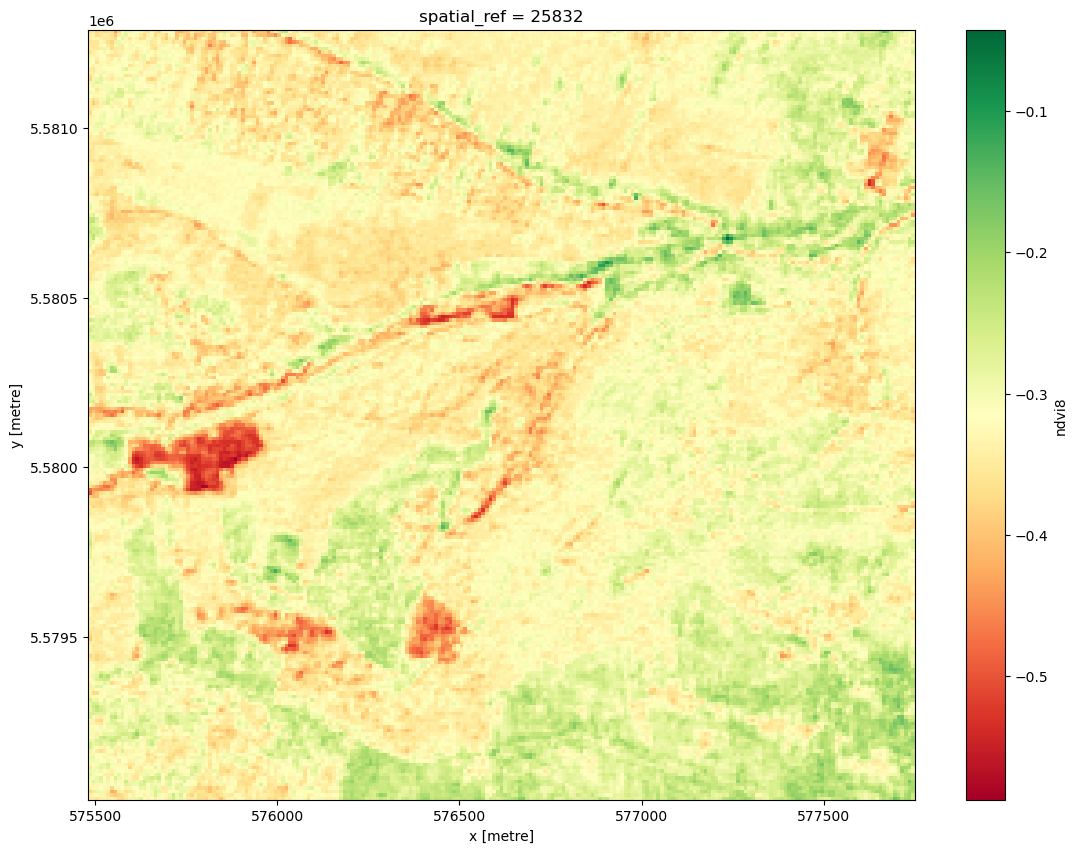

In [38]:
# Plot the NDVI difference
annual.plot.imshow(size=10,cmap='RdYlGn')

In [39]:
# Save results to geotiff
# for tract 17020 for year 7, i.e. 2022
write_cog(geo_im=dataset_clean_all.isel(year=7).ndvi8,fname='17020_ndvi_2022.tif',overwrite=True,use_windowed_writes=True)

NameError: name 'dataset_clean_all' is not defined

In [76]:
# Perform a clustering using
from skimage.segmentation import quickshift
# Produce arrays
input_array = annual.values.astype(np.float64)
# Choose a year 0-7, i.e. 2015-2022
# chose a band or index, e.g. ndvi8, red, ...
input_array = dataset_clean_all.ndvi8.isel(year=6).values.astype(np.float64)
#
# Calculate the segments
segments = quickshift(input_array,
                      kernel_size=2,
                      convert2lab=False,
                      max_dist=10,
                      ratio=1.0)

# Zonal mean calculation
segments_zonal_mean_qs = scipy.ndimage.mean(input=input_array,
                                            labels=segments,
                                            index=segments)

In [77]:
# Take a look at satistics
print('Minimum value',input_array.min(),';','Maximum value',input_array.max(),';','Mean',input_array.mean(),';','Standard deviation',input_array.std())

Minimum value 0.1642978936433792 ; Maximum value 0.8513768315315247 ; Mean 0.6928147193385729 ; Standard deviation 0.06958293952121251


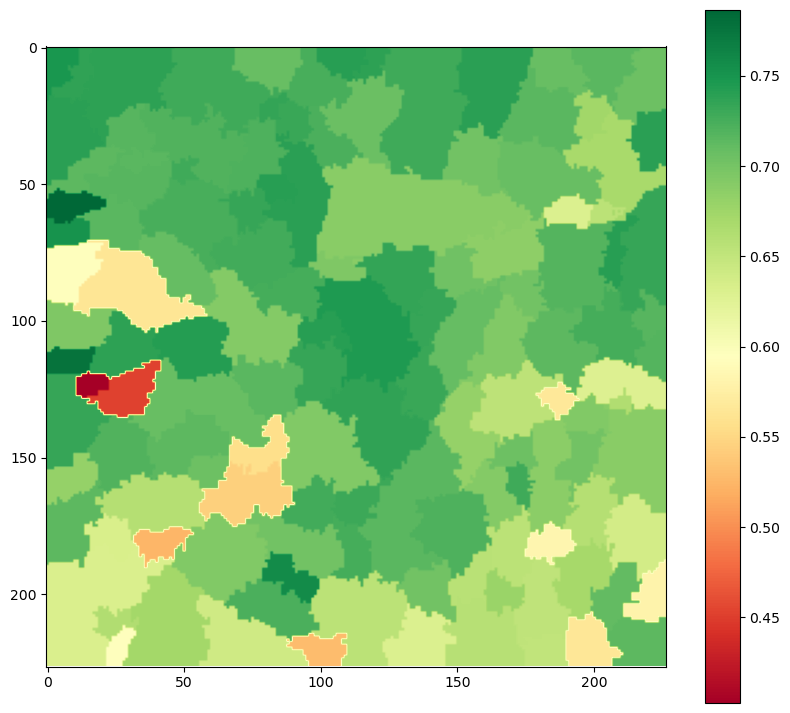

In [78]:
# Plot to see result
plt.figure(figsize=(10, 10))
plt.imshow(segments_zonal_mean_qs, cmap='RdYlGn')#, vmin=0, vmax=1)
plt.colorbar(shrink=0.9)

In [64]:
# Write results to cog
segments_zonal_mean_qs = xr.DataArray(segments_zonal_mean_qs, 
             coords=annual.coords, 
             dims=['y', 'x'], 
             attrs=annual.attrs)

# Write array to GeoTIFF
write_cog(geo_im=segments_zonal_mean_qs,
          fname='masked_data_22.tif',
          overwrite=True);



### K-mans clustering

In [79]:
# DEA functions credits goes to
# https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Real_world_examples/Radar_urban_area_mapping.html
def show_clustered(predicted_ds):
    """
    Takes the predicted xarray DataArray and plots it.

    Last modified: November 2021
    Parameters
    ----------
    predicted_ds : xarray DataArrray
    The xarray DataArray which is the result of the k-means clustering.

    Returns
    -------
    An plot of the predicted_ds.
    """

    # Display predicted_ds Dataset with upto 6 unique classes.
    image = predicted_ds

    # Color list with 6 colors from the virdis color map.
    no_classes = len(np.unique(image))
    colour_list = ["#fde725", "#440154", "#22a884", "#414487", "#DDA0DD", "#7ad151","#7E1E9C"]
    colours = colour_list[:no_classes]
    cmap = mcolours.ListedColormap(colours)
    bounds = range(0, no_classes+1)
    norm = mcolours.BoundaryNorm(np.array(bounds), cmap.N)
    cblabels = [str(i) for i in bounds]
    im = plt.imshow(image,cmap=cmap, norm=norm)
    cb = plt.colorbar(im,cmap=cmap,norm=norm)
    cb.set_ticks(np.linspace(1,3,3)-0.5)
    cb.set_ticklabels(['1','2','3'])
    #cb.set_ticklabels(cblabels)
    plt.axis("off")
    #title = f"K-means Clustering Predicted Image using {no_classes} clusters"
    #plt.title(title)
    #plt.savefig("2016_6_clusters_dry.jpeg", dpi=2000)
    plt.show()


def kmeans_clustering(input_xr, cluster_range):
    """
    Perform sklearn Kmeans clustering on the input Dataset
    or Data Array.

    Parameters
    ----------
    input_xr : xarray.DataArray or xarray.Dataset
        Must have dimensions 'x' and 'y', may have dimension 'time'.

    cluster_range : list
        A list of the number of clusters to use to perform the k-means clustering
        on the input_xr Dataset.

    Returns
    ----------
    results : dictionary
        A dictionary with the number of clusters as keys and the predicted xarray.DataArrays
        as the values. Each predicted xarray.DataArray has the same dimensions 'x', 'y' and
        'time' as the input_xr.

    """

    # Use the sklearn_flatten function to convert the Dataset or DataArray into a 2 dimensional numpy array.
    model_input = sklearn_flatten(input_xr)

    # Standardize the data.
    scaler = StandardScaler()
    model_input = scaler.fit_transform(model_input)

    # Dictionary to save results
    results = {}

    # Perform Kmeans clustering on the input dataset for each number of clusters
    # in the cluster_range list.
    for no_of_clusters in cluster_range:
        # Set up the kmeans classification by specifying the number of clusters
        # with initialization as k-means++.
        km = KMeans(n_clusters=no_of_clusters, init="random", random_state=1)

        # Begin iteratively computing the position of the clusters.
        km.fit(model_input)

        # Use the sklearn kmeans .predict method to assign all the pixels of the
        # model input to a unique cluster.
        flat_predictions = km.predict(model_input)

        # Use the sklearn_unflatten function to convert the flat predictions into a
        # xarray DataArray.
        predicted = sklearn_unflatten(flat_predictions, input_xr)
        predicted = predicted.transpose("y", "x")

        # Append the results to a dictionary using the number of clusters as the
        # column as an key.
        results.update({str(no_of_clusters): predicted})

    return results

K-means clustering first with 2 clusters.

In [100]:
kmeans_clustering?

Signature: kmeans_clustering(input_xr, cluster_range)
Docstring:
Perform sklearn Kmeans clustering on the input Dataset
or Data Array.

Parameters
----------
input_xr : xarray.DataArray or xarray.Dataset
    Must have dimensions 'x' and 'y', may have dimension 'time'.

cluster_range : list
    A list of the number of clusters to use to perform the k-means clustering
    on the input_xr Dataset.

Returns
----------
results : dictionary
    A dictionary with the number of clusters as keys and the predicted xarray.DataArrays
    as the values. Each predicted xarray.DataArray has the same dimensions 'x', 'y' and
    'time' as the input_xr.
File:      /tmp/ipykernel_565/1558703934.py
Type:      function

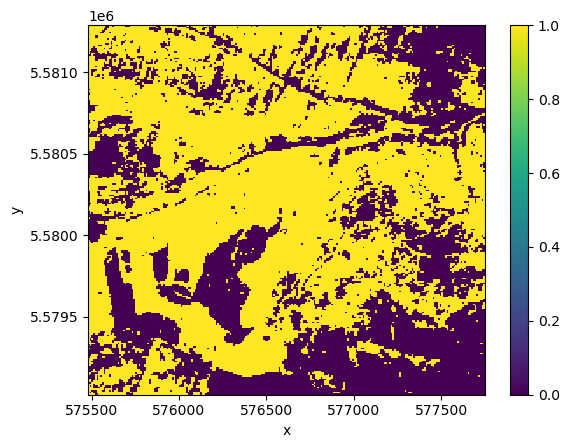

In [111]:
# Define input for clustering
#
median2022 = dataset_clean_all.sel(year=[2022])
# change the input, e.g. from ndvi8 to red
kmean_input = median2022.ndvi8
# Perform clustering
ndvi_kmeans = kmeans_clustering(kmean_input,[2])
# Depnding on the defined clusters will have discrete values
for predicted_ds in ndvi_kmeans.values():
    predicted_ds.plot.imshow()

<xarray.DataArray 'ndvi8' (y: 227, x: 227)>
array([[0.3907563 , 0.39381003, 0.3968254 , ..., 0.50742424, 0.4705659 ,
        0.4967742 ],
       [0.40006518, 0.40972042, 0.38803363, ..., 0.48824352, 0.47841948,
        0.4848973 ],
       [0.41148752, 0.4364137 , 0.41534263, ..., 0.4778462 , 0.47837916,
        0.5036485 ],
       ...,
       [0.3357473 , 0.38088852, 0.48099318, ..., 0.5028608 , 0.5224941 ,
        0.5578729 ],
       [0.42589772, 0.46380812, 0.45047566, ..., 0.5159091 , 0.53095096,
        0.54075986],
       [0.43552423, 0.43082023, 0.39320186, ..., 0.53851706, 0.55328023,
        0.5580401 ]], dtype=float32)
Coordinates:
  * y            (y) float64 5.581e+06 5.581e+06 ... 5.579e+06 5.579e+06
  * x            (x) float64 5.755e+05 5.755e+05 ... 5.777e+05 5.777e+05
    spatial_ref  int32 25832
    year         int64 2022

In [122]:
df=pd.DataFrame(kmean_input.isel(year=0))
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)

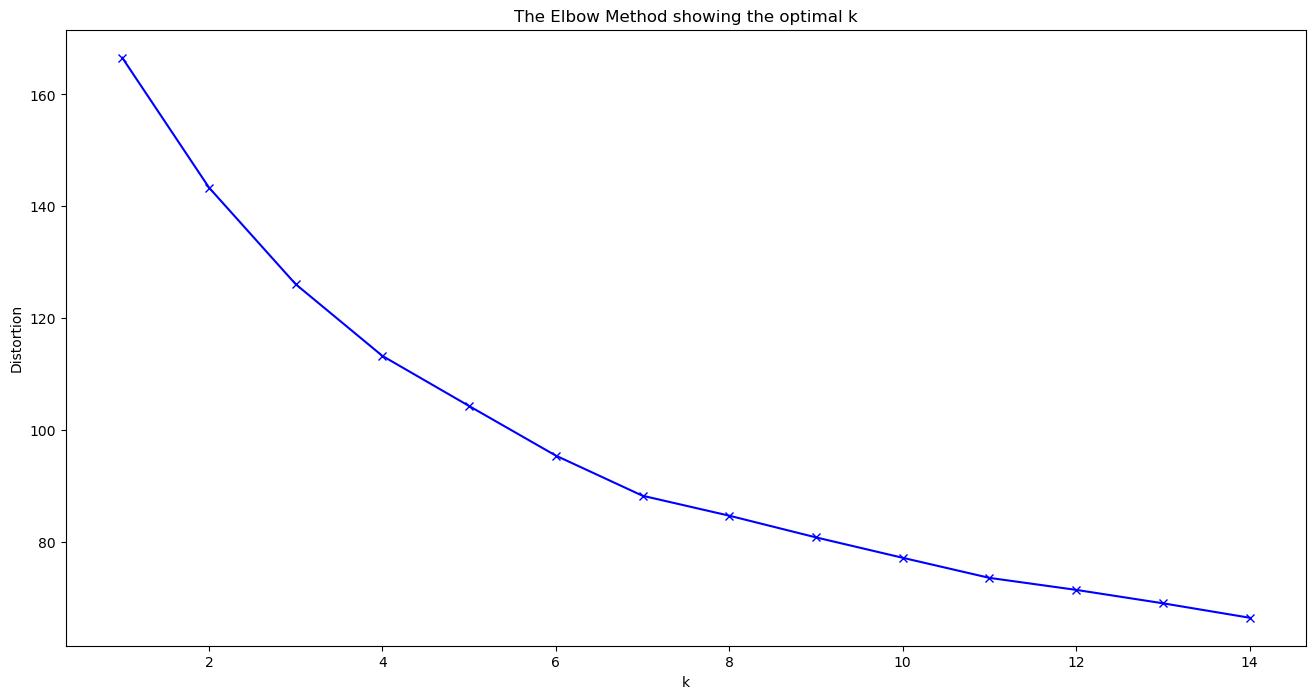

In [123]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Or a more systematic way to investigate a suitable number of clusters for the k-mean algorithm.

In [60]:
# Write results to cog
predicted_ds = xr.DataArray(predicted_ds, 
             coords=annual.coords, 
             dims=['y', 'x'], 
             attrs=annual.attrs)

write_cog(geo_im=predicted_ds,
          fname='kmeans_data_22.tif',
          overwrite=True);

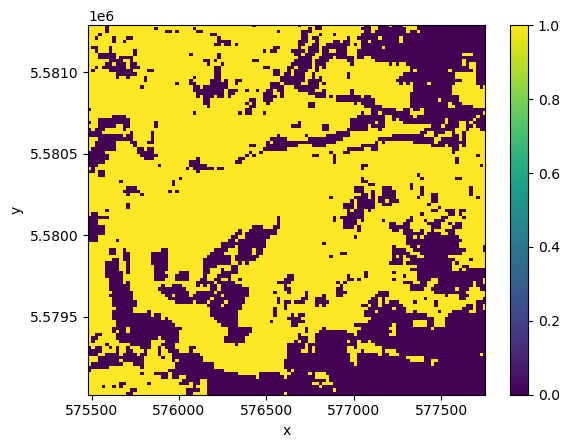

In [69]:
# Define new input for clustering
median2022 = dataset_clean_all.sel(year=[2022])
kmean_input = median2022.ndre1 # HERE
# Perform clustering
ndvi_kmeans = kmeans_clustering(kmean_input, [2])
# Depnding on the defined clusters will have discrete values
for predicted_ds in ndvi_kmeans.values():
    predicted_ds.plot.imshow()

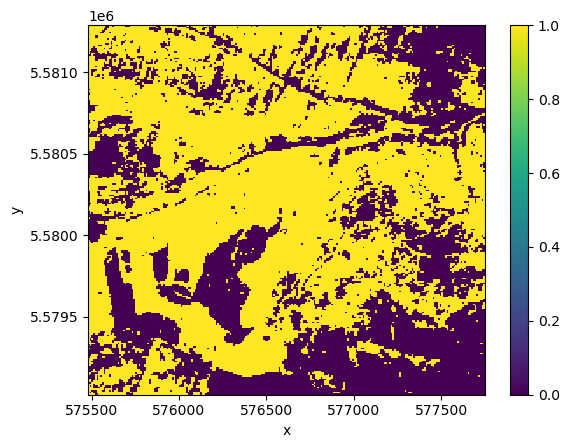

In [71]:
# Add more classes
median2022 = dataset_clean_all.sel(year=[2022])
kmean_input = median2022.ndvi8
# Perform clustering
ndvi_kmeans = kmeans_clustering(kmean_input, [2]) # HERE
# Depnding on the defined clusters will have discrete values
for predicted_ds in ndvi_kmeans.values():
    predicted_ds.plot.imshow()

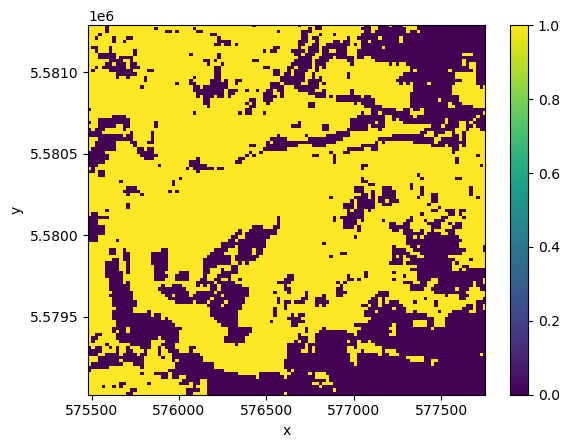

In [72]:
# Define new input for clustering
median2022 = dataset_clean_all.sel(year=[2022])
kmean_input = median2022.ndre1 # HERE
# Perform clustering
ndvi_kmeans = kmeans_clustering(kmean_input, [2])
# Depnding on the defined clusters will have discrete values
for predicted_ds in ndvi_kmeans.values():
    predicted_ds.plot.imshow()